In [1]:
from module import *
from tool import *
from test import *
from tqdm import tqdm
import os
from IPython.display import clear_output

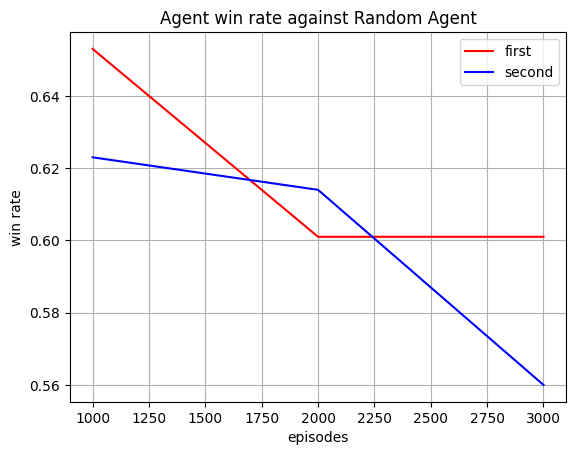

 40%|███▉      | 3999/10000 [22:00<31:19,  3.19it/s]   

In [2]:
env = ConnectFourEnvironment()
input_size = 6 * 7  
output_size = 7 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
agent = DQNAgent(input_size, output_size, device)

model_path = "rew06/"
os.makedirs(model_path)

num_episodes = 10000
epsilon = 1.0
target_update_frequency = 100
update_plot_frequency = 1000
threshold_episodes_save = 5000

results = []

# Training loop
for episode in tqdm(range(num_episodes)):
    state = env.get_state()
    done = False

    new_epsilon = max(0, epsilon - 5 * episode * epsilon / num_episodes)
    while not done:
        action = agent.select_action(state, env, new_epsilon)
        next_state, reward, done = env.step(action)
        
        agent.store_transition(Transition(state, action, next_state, reward))
        agent.train()
        
        state = next_state

    if episode % target_update_frequency == 0:
        agent.update_target_network()
        
    if (episode + 1) % update_plot_frequency == 0:
        if (episode + 1) >= threshold_episodes_save: torch.save(agent.policy_net.state_dict(), os.path.join(model_path, f"{episode + 1}.pth"))
        f, s = TestCase(agent, 2000)
        results.append((episode + 1, f, s))
        clear_output(wait=True)
        update_plot(results)
        
    env.reset()

clear_output(wait=True)
dqn_net = DQN()
with open(os.path.join(model_path, "model.txt"), "w") as f:
    f.write(str(dqn_net) + f"\nEpsilon: {epsilon}\nResults: {results}" )
update_plot(results, os.path.join(model_path, "final.png"))